#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Loading Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Churn_Modelling.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
6,7,15592531,Bartlett,822,NaN,Male,50.0,7,0.00,2,1.0,1.0,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29.0,4,115046.74,4,1.0,0.0,119346.88,1
8,9,15792365,He,501,France,Male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
9,10,15592389,H?,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73,0


# Exploratory Data Analysis (EDA)

This step focuses on investigating and visualizing data to understand its structure. EDA guide subsequent stages of model building, including feature selection, data preprocessing, and model choice, as it helps discover validate assumptions, identify outliers, and understand variable relationships, which are crucial for improving the performance of the classification model. This exploratory phase is essential to enhances model accuracy and mitigates risks of overfitting or bias by ensuring data quality and relevance.

# Handle Missing and Duplicate Data

In [3]:
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,1
Gender,0
Age,1
Tenure,0
Balance,0
NumOfProducts,0


There is one missing value in each of the following columns: Geography, Age, HasCrCard, and IsActiveMember. Since the dataset only has four rows with missing values, I can either drop these rows without significantly impacting the dataset’s overall size or impute the missing values. Imputing these values using the mean for numeric variables and the mode for categorical variables would also maintain data quality, as the small amount of missing data has minimal impact.


In [4]:
df.dropna(inplace=True)

In [5]:
df.duplicated().sum()

2

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(9996, 14)

RowNumber, CustomerId and Surname columns don't provide any meaningful information for predicting customer behavior, they will be dropped from the dataset before modeling.

In [8]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# Identify Numeric and Categorical Variables

In [9]:
numerics= df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary','Tenure','NumOfProducts']]
categoricals= df[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']]

First, Exploratory Data Analysis of numeric variables to understand data distributions and variability, by summarizing key statistics, visualizing distributions, and detecting outliers. This step is essential for identifying issues such as skewness, multicollinearity, or non-normality, which may impact model performance. Comparing the observed data characteristics with the assumptions of the intended machine learning model such as linearity, homoscedasticity, or independence ensures model robustness and validity

In [10]:
numerics.describe()

,CreditScore,Age,Balance,EstimatedSalary,Tenure,NumOfProducts
count,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000
mean,650.503301,38.921071,76476.263216,100106.701248,5.013305,1.530212
std,96.624668,10.488421,62397.118820,57513.314398,2.892353,0.581684
min,350.000000,18.000000,0.000000,11.580000,0.000000,1.000000
25%,584.000000,32.000000,0.000000,51002.110000,3.000000,1.000000
50%,652.000000,37.000000,97173.290000,100238.110000,5.000000,1.000000
75%,717.250000,44.000000,127639.372500,149400.107500,7.250000,2.000000
max,850.000000,92.000000,250898.090000,199992.480000,10.000000,4.000000


Based on the summary statistics, the data may require normalization or standardization for machine learning algorithms sensitive to scale.
Variables like Balance have a minimum value of 0 and a maximum value of over 250,000, suggesting the presence of potential outliers, Balance and EstimatedSalary display high variability, as indicated by their larger standard deviations (62,397.12 and 57,513.31, respectively).
There will be further investigated and visualized to assess its impact on the model's performance and determine if any transformations are needed.

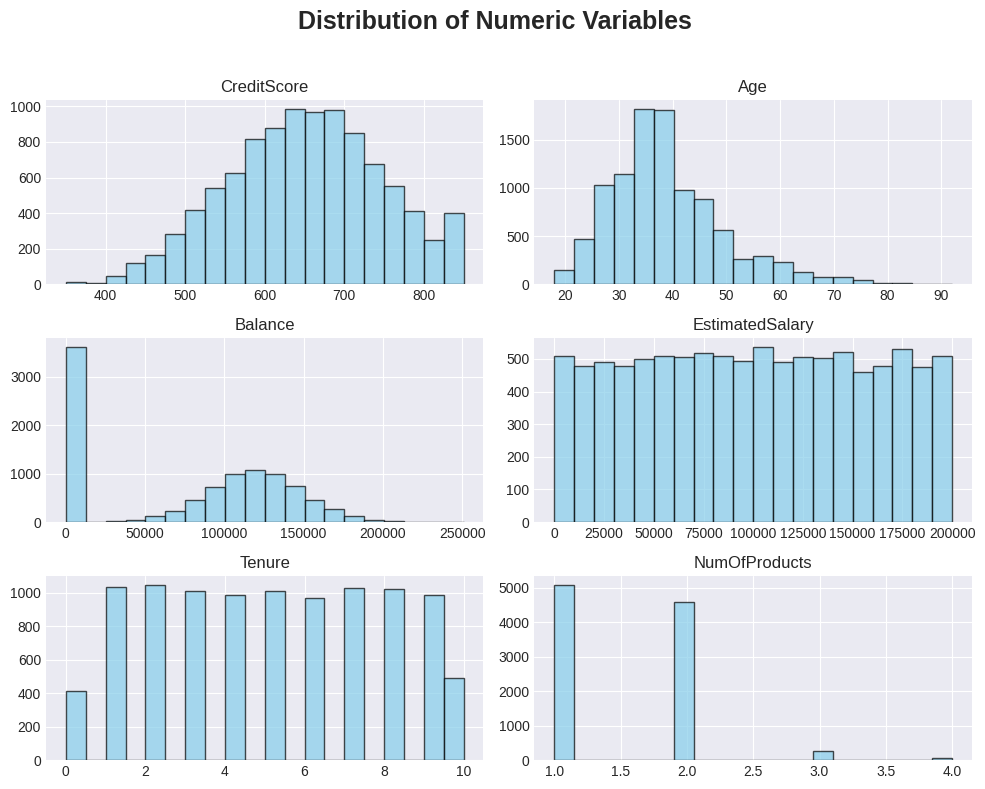

In [11]:
plt.style.use('seaborn-v0_8-darkgrid')
numerics.hist(figsize=(10, 8), bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.suptitle('Distribution of Numeric Variables', fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

There is a high frequency of zero values in the Balance column, which may stands out as unusual. This was already noted during the review of the first 10 rows of data. Further investigation is required to understand why so many customers have a zero balance and how this correlates with other features.

The Age column shows evidence of skewness, which may violate the assumptions of a logistic regression model. A data transformation might be necessary to address this issue and ensure the model's assumptions are met.

<ipython-input-12-9a4af636a375>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=feature, data=df, palette='Blues')
<ipython-input-12-9a4af636a375>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=feature, data=df, palette='Blues')
<ipython-input-12-9a4af636a375>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=feature, data=df, palette='Blues')
<ipython-input-12-9a4af636a375>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14

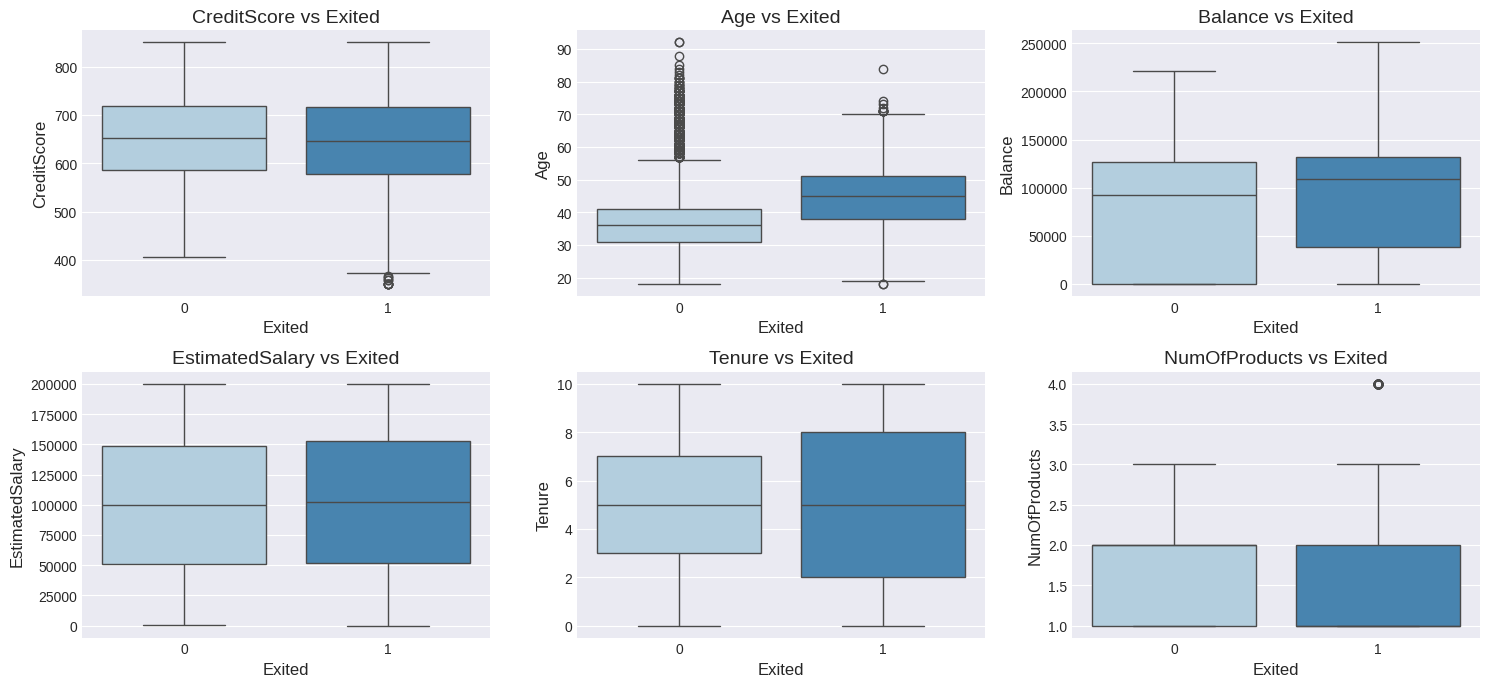

In [12]:
target_variable = 'Exited'

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=target_variable, y=feature, data=df, palette='Blues')
    plt.title(f'{feature} vs {target_variable}', fontsize=14)
    plt.xlabel(target_variable, fontsize=12)
    plt.ylabel(feature, fontsize=12)

plt.tight_layout()
plt.show()

By observing the distrbution of numeric features across categories in target variable, majority of the features may not provide significant information about the target.

Obviously age is the most informative feature.

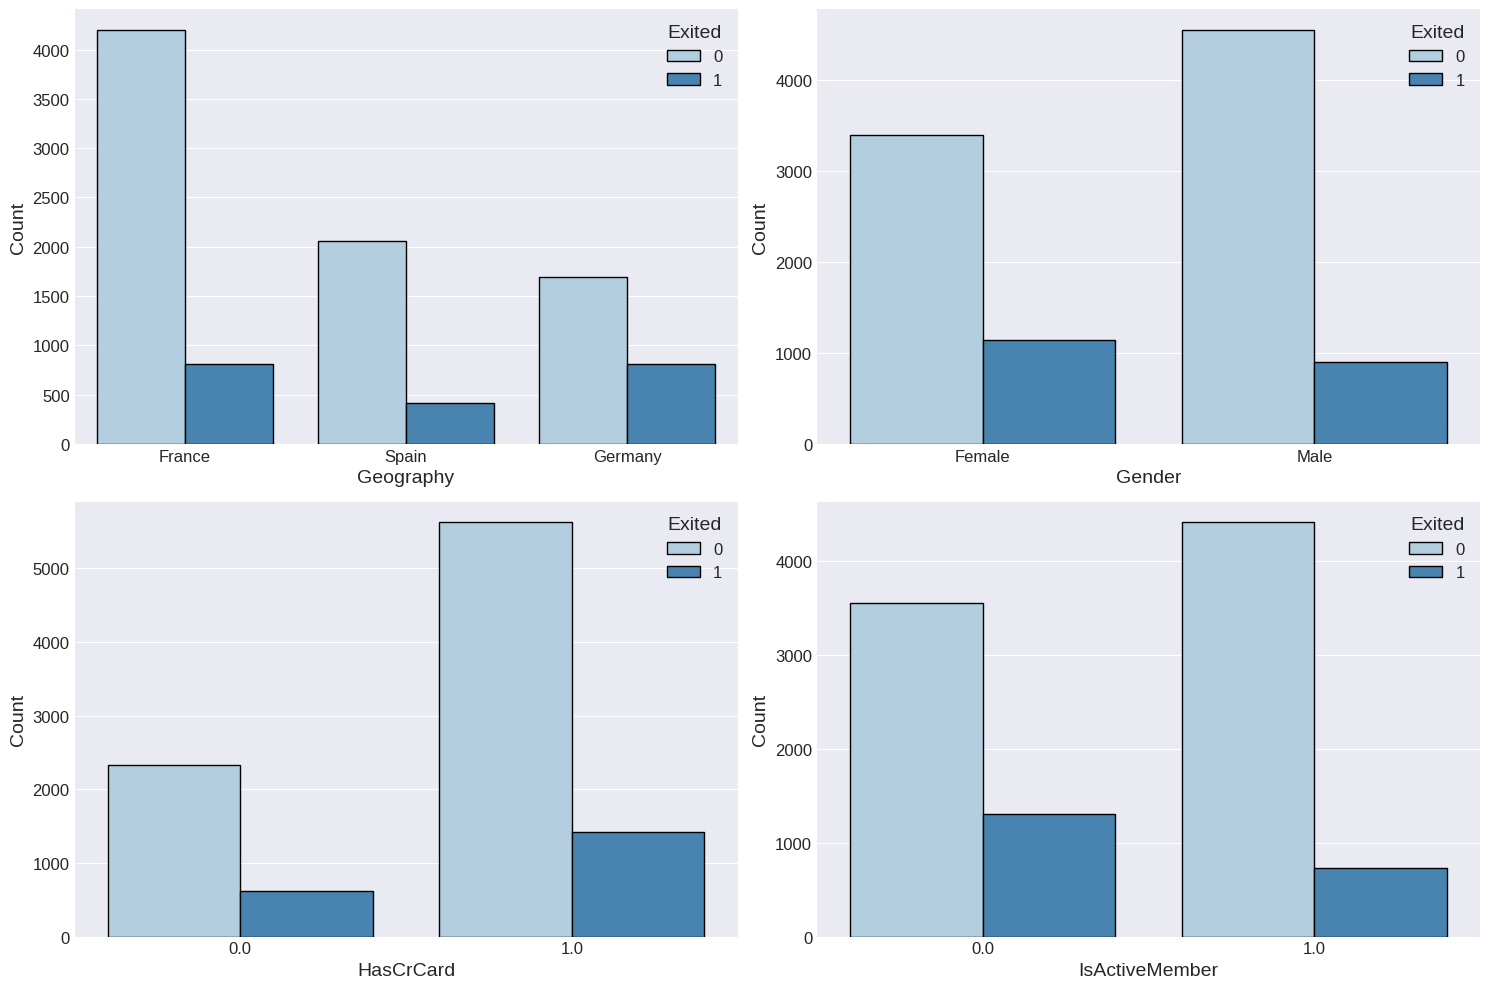

In [13]:
n_cols = 2
n_rows = len(categoricals) // n_cols + (len(categoricals) % n_cols > 0)

fig, axes = plt.subplots(2, 2, figsize=(15, 5 * 2))
axes = axes.flatten()

for i, column in enumerate(categoricals):
    sns.countplot(data=df, x=column, hue='Exited', palette='Blues', edgecolor='black', ax=axes[i])
    axes[i].set_xlabel(column, fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend(title='Exited', fontsize=12, title_fontsize=14)

for j in range(len(categoricals), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

The Geography countplot highlights a noticeable imbalance in the Exited column across different regions. This imbalance is particularly evident in France and Spain, where a significant portion of customers did not exit.

The Gender countplot reveals that females tend to exit at a slightly higher rate than males. However, the difference is not substantial enough to warrant further investigation or to categorize it as a definitive behavioral trend. This observation suggests that while gender may play a role, it is not a primary factor influencing exit behavior in this dataset. same as IsActiveMember.

There is Observant imbalance in HasCrCard column, yet the portion of exited number of customers that doesn't have card is slightly higher comparing to overall category portion.

In [14]:
df['Exited'].value_counts()

,count
Exited,
0,7959
1,2037


The Exited column shows a significant class imbalance, with 80% of customers staying. This imbalance can cause models to exhibit biased predictions, often leading to poor predictive performance for the minority class.

 Addressing class imbalance is crucial for improving model performance and ensuring that predictions are reliable across all classes. Common techniques for handling imbalance include resampling methods like over-sampling the minority class or under-sampling the majority class.

<Axes: >

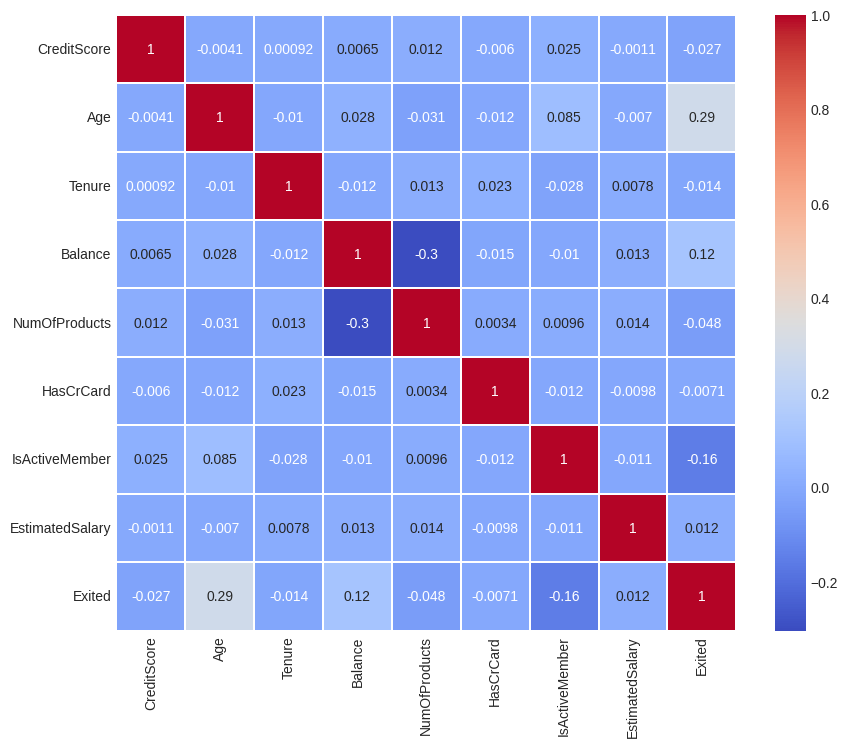

In [15]:
corr_matrix = df[df.select_dtypes(include='number').columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.2)

There is a weak relationship between features and the target. This level of correlation may indicate that the features alone are not strong predictors of the target variable.

This suggests the need for techniques such as feature engineering, polynomial transformations, or tree-based models might help uncover hidden patterns in the data.

The relationship between features is also weak, this ensure that the features are not highly correlated with each other (No multicollinearity).

# Feature Engineering

In this section, I apply feature engineering techniques to create new features based on existing columns in the dataset. These engineered features will help to capture more meaningful relationships in the data and improve model performance.

In [16]:
df['Balance_to_Salary'] = df['Balance'] / df['EstimatedSalary']

In [17]:
df['Balance_to_Products'] = df['Balance'] / df['NumOfProducts']

In [18]:
age_bins = [18, 30, 40, 50, 60, 92]
age_labels = ['18-30', '31-40', '41-50', '51-60', '61+']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

credit_bins = [350, 580, 670, 740, 800, 850]
credit_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
df['CreditScore_Group'] = pd.cut(df['CreditScore'], bins=credit_bins, labels=credit_labels, right=False)



# Data Preprocessing

Encoding categorical features

In [19]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

In [20]:
df = pd.get_dummies(df, columns=['Geography'])

In [21]:
label_encoder = LabelEncoder()
df['CreditScore_Group'] = label_encoder.fit_transform(df['CreditScore_Group'])

In [22]:
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

In [23]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_to_Salary,Balance_to_Products,Age_Group,CreditScore_Group,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42.0,2,0.00,1,1.0,1.0,101348.88,1,0.000000,0.000000,41-50,1,1,0,0
1,608,0,41.0,1,83807.86,1,0.0,1.0,112542.58,0,0.744677,83807.860000,41-50,1,0,0,1
2,502,0,42.0,8,159660.80,3,1.0,0.0,113931.57,1,1.401375,53220.266667,41-50,3,1,0,0
3,699,0,39.0,1,0.00,2,0.0,0.0,93826.63,0,0.000000,0.000000,31-40,2,1,0,0
5,645,1,44.0,8,113755.78,2,1.0,0.0,149756.71,1,0.759604,56877.890000,41-50,1,0,0,1


In [24]:
df.drop(['Age_Group','CreditScore','Balance_to_Products'], axis=1, inplace=True)

# Splitting data

In [25]:
X = df.drop('Exited', axis=1)
y = df['Exited']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Normalizing features to ensure they are on a similar scale

In [26]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

# Models Training

In the phase, I will train various machine learning algorithms, including Logistic Regression, Decision Tree and Random Forest to identify the most effective model. The model that demonstrates the best initial performance will undergo hyperparameter tuning via GridSearchCV to further enhance its efficacy.
I will Train the models before and after data resampling to see how imbalance data can effect the model performance.

# Logistic Regression

In [28]:
model = LogisticRegression(max_iter=500)
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'C': 0.01, 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
model = LogisticRegression()
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
conf_matrix = confusion_matrix(test_y, y_pred)
class_report = classification_report(test_y, y_pred)

print("Test Classification Report:\n", class_report)
train_predictions = model.predict(train_X)
train_f1 = f1_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)
class_report1 = classification_report(train_y, train_predictions)
print(print("Train Classification Report:\n", class_report1))

print("Accuracy:", accuracy)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      2388
           1       0.59      0.22      0.32       611

    accuracy                           0.81      2999
   macro avg       0.71      0.59      0.60      2999
weighted avg       0.78      0.81      0.77      2999

Train Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      5571
           1       0.61      0.20      0.30      1426

    accuracy                           0.81      6997
   macro avg       0.72      0.58      0.60      6997
weighted avg       0.78      0.81      0.77      6997

None
Accuracy: 0.8092697565855285


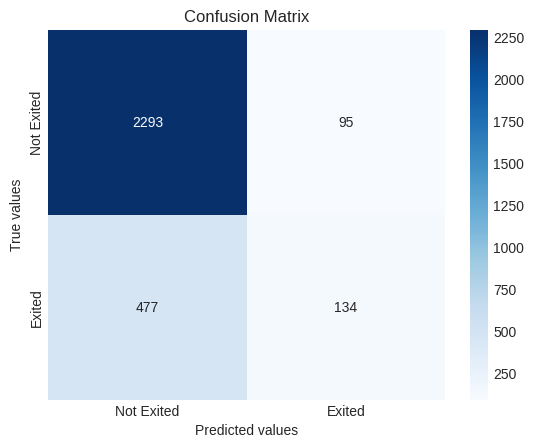

In [28]:
y_true=test_y
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Exited", "Exited"])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Exited", "Exited"], yticklabels=["Not Exited", "Exited"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

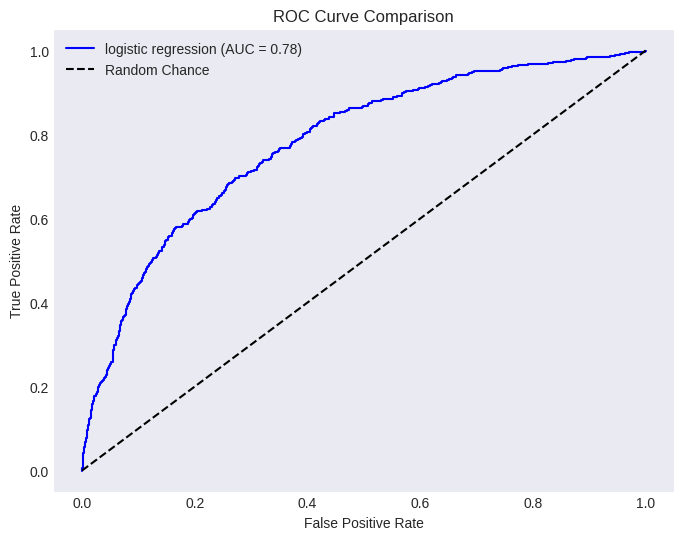

In [29]:
y_prob_lr = model.predict_proba(test_X)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(test_y, y_prob_lr)
auc_lr = roc_auc_score(test_y, y_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'logistic regression (AUC = {auc_lr:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# Decision Tree

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_X, train_y)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [37]:
clf = DecisionTreeClassifier(criterion= 'entropy', max_depth = 10, min_samples_leaf= 4, min_samples_split= 2, random_state=42)
clf.fit(train_X, train_y)

y_pred = clf.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)

class_report = classification_report(test_y, y_pred)
print("Test Classification Report:\n", class_report)
print("Accuracy:", accuracy)

train_predictions = clf.predict(train_X)
train_f1 = f1_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)

class_report1 = classification_report(train_y, train_predictions)
print("\n Train Classification Report:\n", class_report1)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2388
           1       0.69      0.49      0.57       611

    accuracy                           0.85      2999
   macro avg       0.78      0.72      0.74      2999
weighted avg       0.84      0.85      0.84      2999

Accuracy: 0.8509503167722574

 Train Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      5571
           1       0.83      0.57      0.68      1426

    accuracy                           0.89      6997
   macro avg       0.86      0.77      0.80      6997
weighted avg       0.88      0.89      0.88      6997



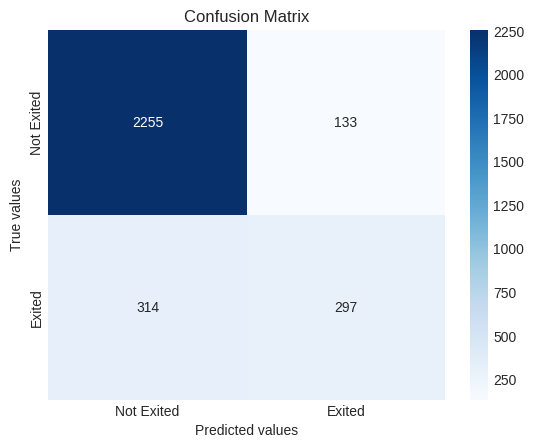

In [31]:
y_true=test_y
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Exited", "Exited"])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Exited", "Exited"], yticklabels=["Not Exited", "Exited"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

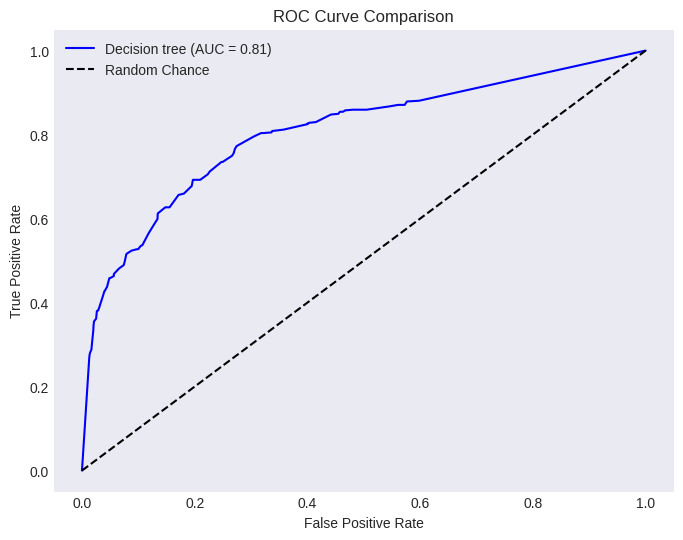

In [34]:
y_prob_clf = clf.predict_proba(test_X)[:, 1]
fpr_clf, tpr_clf, _ = roc_curve(test_y, y_prob_clf)
auc_clf = roc_auc_score(test_y, y_prob_clf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_clf, tpr_clf, label=f'Decision tree (AUC = {auc_clf:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for classifier
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_X, train_y)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [38]:
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf= 2, min_samples_split= 10, random_state=42)

# Train the model
rf_clf.fit(train_X, train_y)

y_pred = rf_clf.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)

class_report = classification_report(test_y, y_pred)
print("Test Classification Report:\n", class_report)

print("Accuracy:", accuracy)


train_predictions = rf_clf.predict(train_X)
train_f1 = f1_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)

class_report1 = classification_report(train_y, train_predictions)
print("\n Train Classification Report:\n", class_report1)


Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      2388
           1       0.79      0.47      0.59       611

    accuracy                           0.87      2999
   macro avg       0.84      0.72      0.76      2999
weighted avg       0.86      0.87      0.85      2999

Accuracy: 0.8679559853284429

 Train Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      5571
           1       0.95      0.63      0.76      1426

    accuracy                           0.92      6997
   macro avg       0.93      0.81      0.86      6997
weighted avg       0.92      0.92      0.91      6997



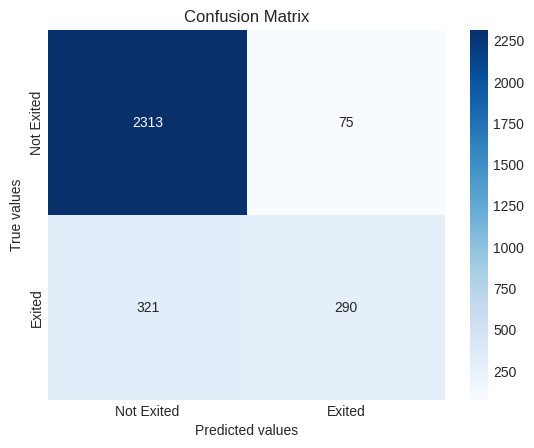

In [39]:
y_true=test_y
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Exited", "Exited"])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Exited", "Exited"], yticklabels=["Not Exited", "Exited"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

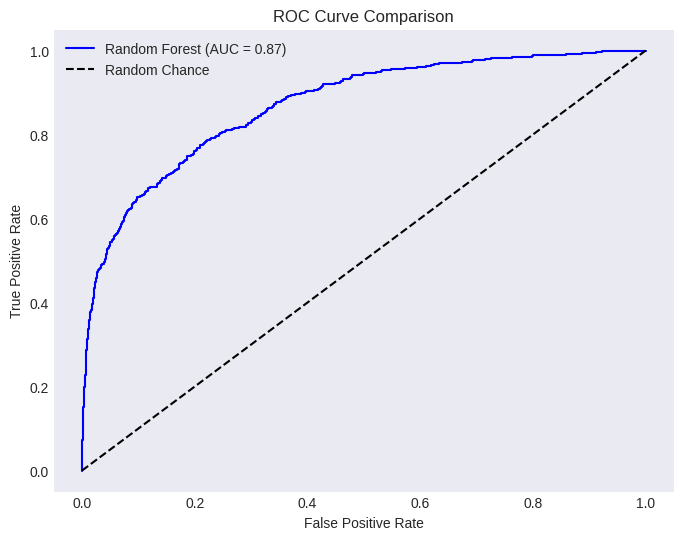

In [36]:
y_prob_rf = rf_clf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_y, y_prob_rf)
auc_rf = roc_auc_score(test_y, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# Train Models with resampling

In [52]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
print("Resampled class distribution:", dict(zip(*np.unique(y_resampled, return_counts=True))))

Resampled class distribution: {0: 7959, 1: 7959}


# Logistic Regression

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)
print("\n Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      1620
           1       0.83      0.76      0.80      1564

    accuracy                           0.81      3184
   macro avg       0.81      0.81      0.81      3184
weighted avg       0.81      0.81      0.81      3184


 Accuracy: 0.8090452261306532


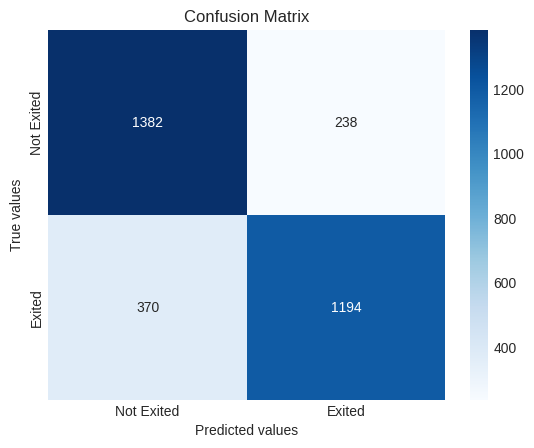

In [58]:
y_true=y_test
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Exited", "Exited"])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Exited", "Exited"], yticklabels=["Not Exited", "Exited"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

# Decision Tree

In [61]:
clf = DecisionTreeClassifier(criterion= 'entropy', max_depth = 10, min_samples_leaf= 4, min_samples_split= 2, random_state=42)

# Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print("\n Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1620
           1       0.87      0.82      0.85      1564

    accuracy                           0.85      3184
   macro avg       0.85      0.85      0.85      3184
weighted avg       0.85      0.85      0.85      3184


 Accuracy: 0.8527010050251256


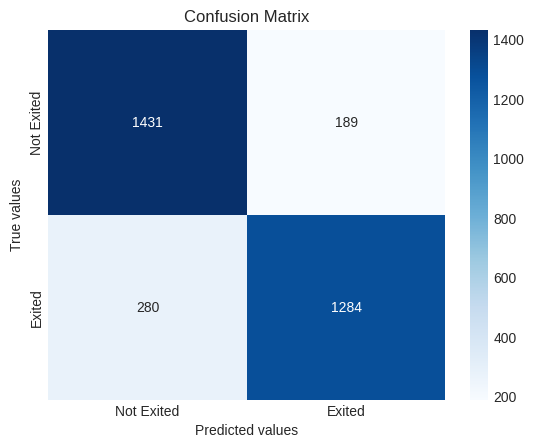

In [62]:
y_true=y_test
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Exited", "Exited"])

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Exited", "Exited"], yticklabels=["Not Exited", "Exited"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

# Random Forest

In [63]:
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf= 2, min_samples_split= 10, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print("\n Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1620
           1       0.92      0.87      0.89      1564

    accuracy                           0.90      3184
   macro avg       0.90      0.89      0.89      3184
weighted avg       0.90      0.90      0.89      3184


 Accuracy: 0.8951005025125628


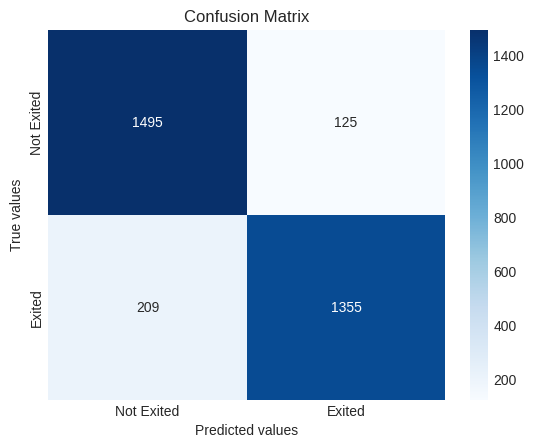

In [65]:
y_true=y_test
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Exited", "Exited"])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Exited", "Exited"], yticklabels=["Not Exited", "Exited"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

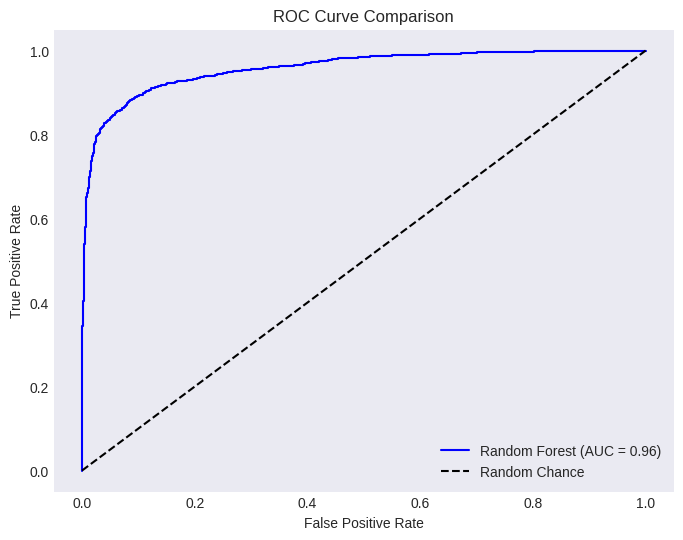

In [66]:
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()